In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from xgboost import plot_tree
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
import xgboost
import shap
import os
from matplotlib import animation

In [2]:
df = pd.read_csv('data/responses.csv')
df=df[df.columns[-77:]]
df_original=df.copy()
df.head()

Smoking         Alcohol  Healthy eating  Daily events  \
0   never smoked     drink a lot             4.0           2.0   
1   never smoked     drink a lot             3.0           3.0   
2  tried smoking     drink a lot             3.0           1.0   
3  former smoker     drink a lot             3.0           4.0   
4  tried smoking  social drinker             4.0           3.0   

   Prioritising workload  Writing notes  Workaholism  Thinking ahead  \
0                    2.0            5.0          4.0             2.0   
1                    2.0            4.0          5.0             4.0   
2                    2.0            5.0          3.0             5.0   
3                    4.0            4.0          5.0             3.0   
4                    1.0            2.0          3.0             5.0   

   Final judgement  Reliability  ...   Age  Height  Weight  \
0              5.0          4.0  ...  20.0   163.0    48.0   
1              1.0          4.0  ...  19.0   163.0    58.0   
2              3.0          4.0  ...  20.0   176.0    67.0   
3              1.0          3.0  ...  22.0   172.0    59.0   
4              5.0          5.0  ...  20.0   170.0    59.0   

   Number of siblings  Gender  Left - right handed                Education  \
0                 1.0  female         right handed  college/bachelor degree   
1                 2.0  female         right handed  college/bachelor degree   
2                 2.0  female         right handed         secondary school   
3                 1.0  female         right handed  college/bachelor degree   
4                 1.0  female         right handed         secondary school   

   Only child  Village - town  House - block of flats  
0          no         village          block of flats  
1          no            city          block of flats  
2          no            city          block of flats  
3         yes            city          house/bungalow  
4          no         village          house/bungalow  

[5 rows x 77 columns]

In [3]:
columns=df.columns.tolist()
print(columns)
for col in columns:
    print(col, df[col].dtypes)

['Smoking', 'Alcohol', 'Healthy eating', 'Daily events', 'Prioritising workload', 'Writing notes', 'Workaholism', 'Thinking ahead', 'Final judgement', 'Reliability', 'Keeping promises', 'Loss of interest', 'Friends versus money', 'Funniness', 'Fake', 'Criminal damage', 'Decision making', 'Elections', 'Self-criticism', 'Judgment calls', 'Hypochondria', 'Empathy', 'Eating to survive', 'Giving', 'Compassion to animals', 'Borrowed stuff', 'Loneliness', 'Cheating in school', 'Health', 'Changing the past', 'God', 'Dreams', 'Charity', 'Number of friends', 'Punctuality', 'Lying', 'Waiting', 'New environment', 'Mood swings', 'Appearence and gestures', 'Socializing', 'Achievements', 'Responding to a serious letter', 'Children', 'Assertiveness', 'Getting angry', 'Knowing the right people', 'Public speaking', 'Unpopularity', 'Life struggles', 'Happiness in life', 'Energy levels', 'Small - big dogs', 'Personality', 'Finding lost valuables', 'Getting up', 'Interests or hobbies', "Parents' advice", '

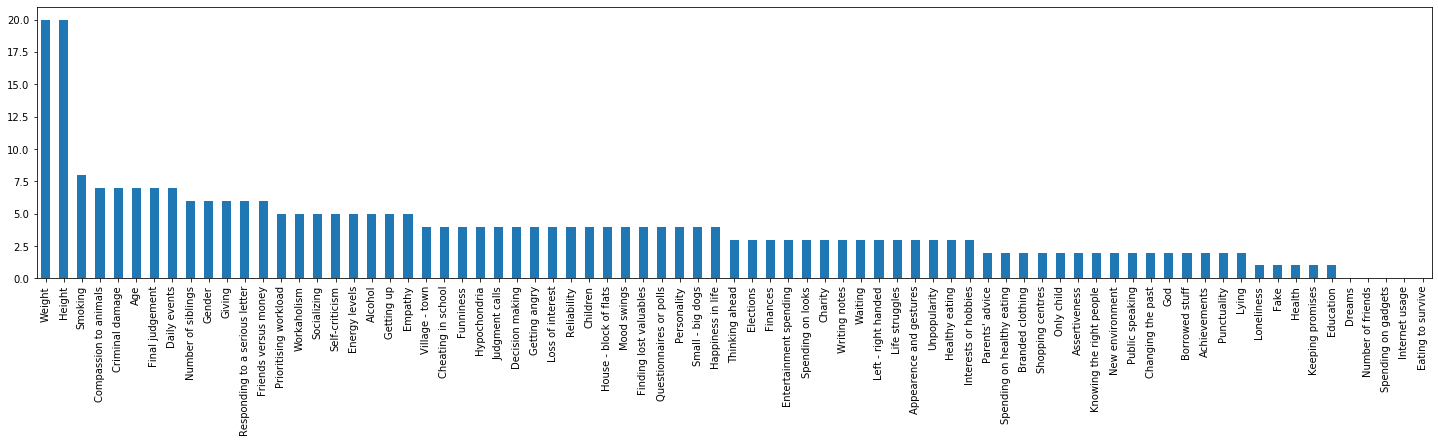

In [4]:
#number of null values per category
nulls = df.isnull().sum().sort_values(ascending=False)
nulls.plot(kind='bar', figsize=(25, 5))

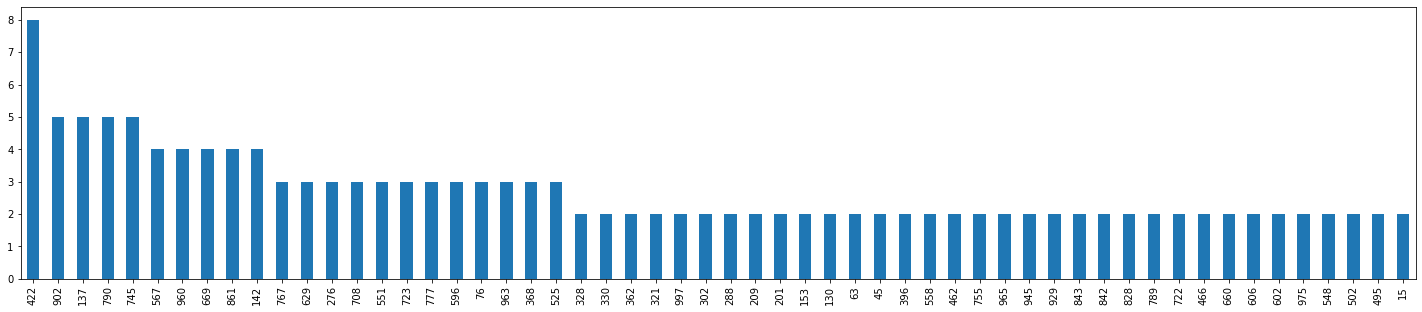

In [5]:
#number of null values per entry (more than 1 missing value)
nulls = df.isnull().sum(axis=1)[df.isnull().sum(axis=1)>1].sort_values(ascending=False)
nulls.plot(kind='bar', figsize=(25, 5))

(array([0, 1]), <a list of 2 Text yticklabel objects>)

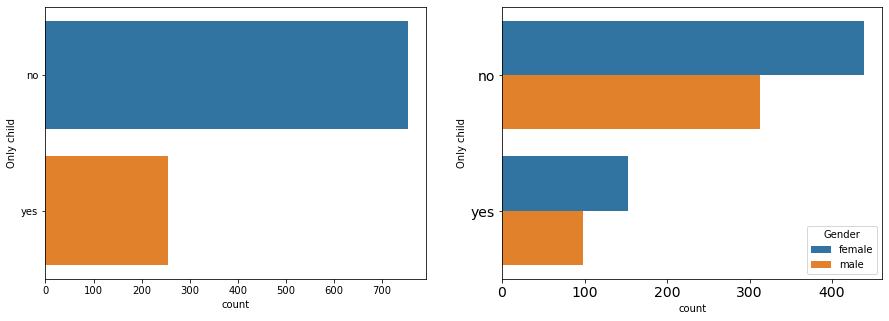

In [6]:
var_of_interest = 'Village - town'
var_of_interest = 'Only child'
df.dropna(subset=[var_of_interest], inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(y=var_of_interest, data=df, ax=ax[0])
sns.countplot(y=var_of_interest, hue='Gender', data=df, ax=ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [38]:
#let us clean up stuff and make it numerical to get it ready for comparision, prediction tasks
def clean_data():
    df=None
    df = pd.read_csv('data/responses.csv')
    print(df.Education.unique())
    mapping = {"Village - town": {'city': 0, 'village': 1}}
    df.replace(mapping, inplace=True)

    mapping_gender = {"Gender": {'male': 0, 'female': 1}}
    df.replace(mapping_gender, inplace=True)

    mapping_house = {"House - block of flats": {'block of flats': 0, 'house/bungalow': 1}}
    df.replace(mapping_house, inplace=True)

    mapping_child = {"Only child": {'no': 0, 'yes': 1}}
    df.replace(mapping_child, inplace=True)

    mapping_hand = {"Left - right handed": {'left handed': 0, 'right handed': 1}}
    df.replace(mapping_hand, inplace=True)

    mapping_smoking = {"Smoking": {'never smoked':1, 'tried smoking':2, 'former smoker':3, 'current smoker':4}}
    df.replace(mapping_smoking, inplace=True)
    #df.Smoking.fillna(0, inplace=True)

    mapping_alc = {"Alcohol": {'drink a lot':3, 'social drinker':2, 'never':1}}
    df.replace(mapping_alc, inplace=True)
    #df.Alcohol.fillna(0, inplace=True)

    mapping_punct = {"Punctuality": {'i am always on time':2, 'i am often early':1, 'i am often running late':3}}
    df.replace(mapping_punct, inplace=True)
    #df.Punctuality.fillna(0, inplace=True)

    mapping_lying = {"Lying": {'never':1, 'sometimes':2, 'only to avoid hurting someone':3,'everytime it suits me':4}}
    df.replace(mapping_lying, inplace=True)
    #df.Lying.fillna(0, inplace=True)

    mapping_internet = {"Internet usage": {'few hours a day':3,'most of the day':4,'less than an hour a day':2,'no time at all':1}}
    df.replace(mapping_internet, inplace=True)
    #df["Internet usage"].fillna(0, inplace=True)

    mapping_education = {"Education": {'college/bachelor degree':4, 'secondary school':3, 'primary school':2,'masters degree':5, 'doctorate degree':6, 'currently a primary school pupil':1}}
    df.replace(mapping_education, inplace=True)
    df.Education.fillna(0, inplace=True)
    print(df.Education.unique())

    for c in range(2):
        print("Prozent female in",c,"is",df.Gender[df.Gender==1][df["Village - town"]==c].sum()/(len(df.Gender[df.Gender==0][df["Village - town"]==c])+df.Gender[df.Gender==1][df["Village - town"]==c].sum()))
    df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    df.dropna(subset=["Happiness_in_life"],inplace=True)
    df.fillna(df.median(),inplace=True)
    return df   
clean_data()

['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil'
 nan]
[4. 3. 2. 5. 6. 1. 0.]
Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378


Music  Slow_songs_or_fast_songs  Dance  Folk  Country  Classical_music  \
0       5.0                       3.0    2.0   1.0      2.0              2.0   
1       4.0                       4.0    2.0   1.0      1.0              1.0   
2       5.0                       5.0    2.0   2.0      3.0              4.0   
4       5.0                       3.0    4.0   3.0      2.0              4.0   
5       5.0                       3.0    2.0   3.0      2.0              3.0   
...     ...                       ...    ...   ...      ...              ...   
1004    5.0                       3.0    4.0   1.0      2.0              3.0   
1005    5.0                       2.0    5.0   2.0      2.0              5.0   
1007    4.0                       3.0    1.0   1.0      2.0              2.0   
1008    5.0                       3.0    3.0   3.0      1.0              3.0   
1009    5.0                       5.0    4.0   3.0      2.0              3.0   

      Musical  Pop  Rock  Metal_or_Hardrock  ...   Age  Height  Weight  \
0         1.0  5.0   5.0                1.0  ...  20.0   163.0    48.0   
1         2.0  3.0   5.0                4.0  ...  19.0   163.0    58.0   
2         5.0  3.0   5.0                3.0  ...  20.0   176.0    67.0   
4         3.0  5.0   3.0                1.0  ...  20.0   170.0    59.0   
5         3.0  2.0   5.0                5.0  ...  20.0   186.0    77.0   
...       ...  ...   ...                ...  ...   ...     ...     ...   
1004      2.0  3.0   3.0                4.0  ...  22.0   175.0    60.0   
1005      4.0  4.0   4.0                3.0  ...  20.0   164.0    57.0   
1007      2.0  3.0   4.0                1.0  ...  18.0   173.0    75.0   
1008      1.0  3.0   4.0                1.0  ...  25.0   173.0    58.0   
1009      3.0  4.0   1.0                1.0  ...  21.0   185.0    72.0   

      Number_of_siblings  Gender  Left_-_right_handed  Education  Only_child  \
0                    1.0     1.0                  1.0        4.0         0.0   
1                    2.0     1.0                  1.0        4.0         0.0   
2                    2.0     1.0                  1.0        3.0         0.0   
4                    1.0     1.0                  1.0        3.0         0.0   
5                    1.0     0.0                  1.0        3.0         0.0   
...                  ...     ...                  ...        ...         ...   
1004                 1.0     0.0                  1.0        3.0         0.0   
1005                 1.0     1.0                  1.0        3.0         0.0   
1007                 0.0     1.0                  1.0        3.0         1.0   
1008                 1.0     1.0                  1.0        4.0         0.0   
1009                 1.0     0.0                  1.0        3.0         0.0   

      Village_-_town  House_-_block_of_flats  
0                1.0                     0.0  
1                0.0                     0.0  
2                0.0                     0.0  
4                1.0                     1.0  
5                0.0                     0.0  
...              ...                     ...  
1004             0.0                     0.0  
1005             0.0                     1.0  
1007             0.0                     0.0  
1008             0.0                     0.0  
1009             1.0                     1.0  

[674 rows x 150 columns]

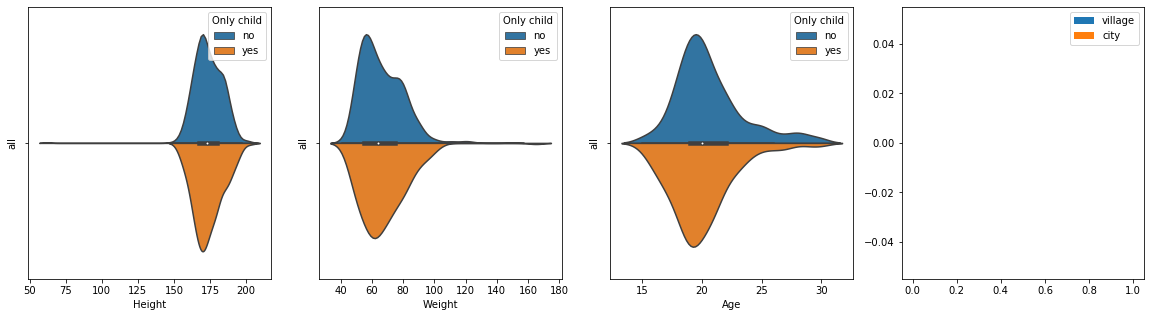

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
df["all"] = ""
data = df.dropna(subset=['Height'])
sns.violinplot(x='Height', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[0]);
data = df.dropna(subset=['Weight'])
sns.violinplot(x='Weight', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[1]);
data = df.dropna(subset=['Age'])
sns.violinplot(x='Age', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[2]);

var_of_int_ser = df[var_of_interest]
plt.hist([df[var_of_int_ser==1].Age.dropna(),df[var_of_int_ser==0].Age.dropna()],
             label=['village','city'], stacked=True, bins=30);
ax[3].legend()

['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil'
 nan]
[4. 3. 2. 5. 6. 1. 0.]
Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378


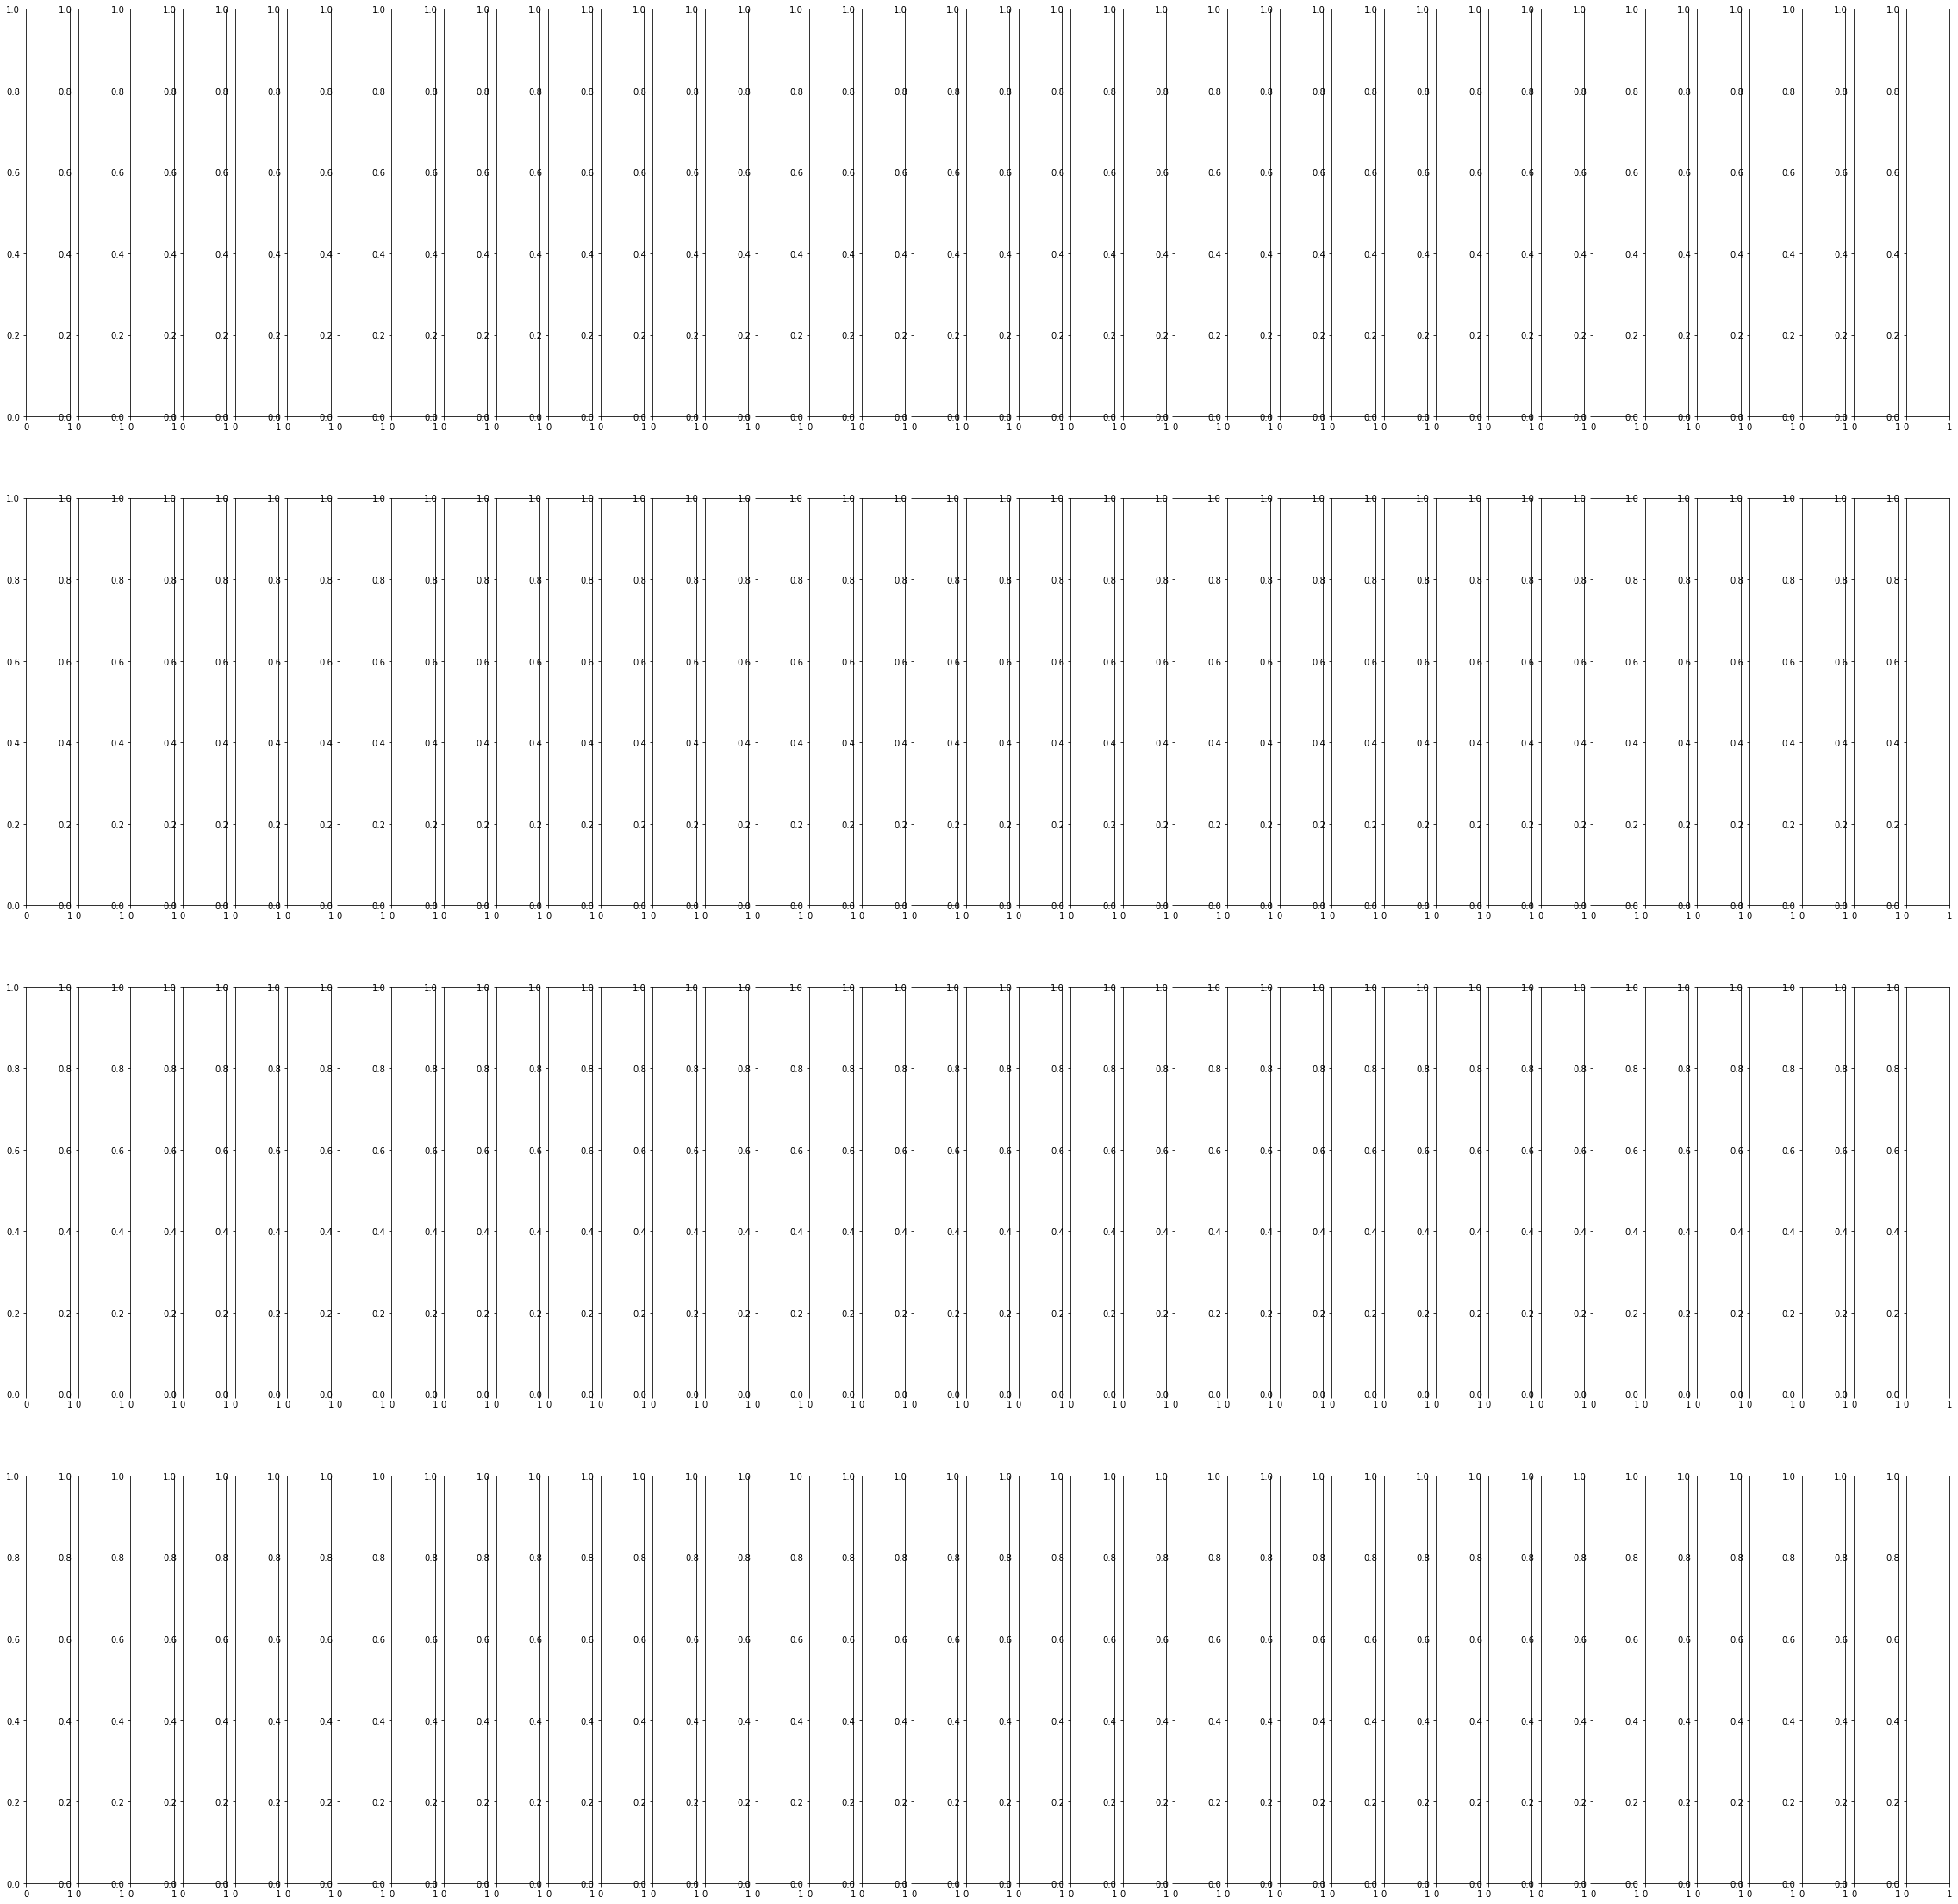

In [23]:
var_of_interest="Happiness_in_life"
df=clean_data()
numerics=df.select_dtypes(include=['int64','float64','uint8','int32','bool'])
numeric_columns=numerics.columns.tolist()
numerics["all"] = ""
fig, ax = plt.subplots(nrows=4, ncols=len(numeric_columns)//4, figsize=(40,40))
for i in range(len(numeric_columns)):
    data = df.dropna(subset=[numeric_columns[i]])
    try:
        sns.violinplot(x=numeric_columns[i], y = "all", hue=var_of_interest, data=numerics, split=True, ax = ax[i//(len(numeric_columns)//4),i%(len(numeric_columns)//4)])
    except:
        continue
    ax[i//(len(numeric_columns)//4),i%(len(numeric_columns)//4)].legend()
plt.show()

                             Music  Slow_songs_or_fast_songs     Dance  \
Music                     1.000000                  0.099509  0.081192   
Slow_songs_or_fast_songs  0.099509                  1.000000  0.194095   
Dance                     0.081192                  0.194095  1.000000   
Folk                      0.029623                 -0.061802  0.065153   
Country                  -0.008145                 -0.071619  0.058482   
...                            ...                       ...       ...   
Left_-_right_handed       0.034851                  0.051913  0.026568   
Education                -0.071058                 -0.022188 -0.011047   
Only_child               -0.020996                 -0.003402 -0.028668   
Village_-_town           -0.000227                  0.005237  0.061761   
House_-_block_of_flats   -0.012553                  0.017680  0.051106   

                              Folk   Country  Classical_music   Musical  \
Music                     0.029623 -

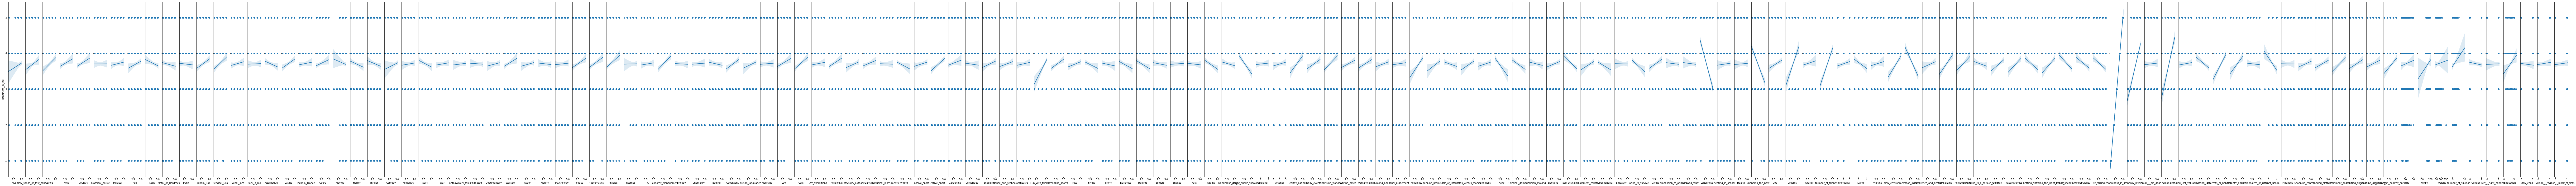

In [24]:
#exploratory analysis of correlations between variables. Don't say anything about causations when inspected like this.
print(numerics.corr())
#revenue and budget seems fairly correlated with a Spearman's correlation coefficent of 0.69 (excluding 0-values for revenue and budget in the records)
print()
#pair plot
g=sns.pairplot(data=numerics,y_vars=var_of_interest,x_vars=numeric_columns,kind="reg")
g.fig.set_size_inches(150,15)

In [25]:
numerics.drop(columns=["all"],inplace=True) #careful is happening inPlace for now
numerics.drop(columns=[var_of_interest],inplace=True)

numerics.fillna(numerics.mean(),inplace=True)
print(numerics.mean())
X = np.array(numerics)
print(X)
y = np.array(df[var_of_interest].fillna(0))
X_train, X_dev, y_train, y_dev=train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
clf_reg = LogisticRegressionCV(Cs=10,cv=5,solver='liblinear',class_weight='balanced',penalty='l1',scoring='roc_auc', random_state=42).fit(X_train,y_train)

Music                       4.732673
Slow_songs_or_fast_songs    3.327723
Dance                       3.112871
Folk                        2.287129
Country                     2.122772
                              ...   
Left_-_right_handed         0.900000
Education                   3.283168
Only_child                  0.251485
Village_-_town              0.296040
House_-_block_of_flats      0.406931
Length: 149, dtype: float64
[[5. 3. 2. ... 0. 1. 0.]
 [4. 4. 2. ... 0. 0. 0.]
 [5. 5. 2. ... 0. 0. 0.]
 ...
 [4. 3. 1. ... 1. 0. 0.]
 [5. 3. 3. ... 0. 0. 0.]
 [5. 5. 4. ... 0. 1. 1.]]


In [26]:
y_predict = clf_reg.predict(X_dev)
score = accuracy_score(y_dev, y_predict)
confusion=confusion_matrix(y_dev, y_predict)
print("Accuracy: %f" % (score))
print(confusion)

Accuracy: 0.306931
[[ 0  1  1  0  0]
 [ 1  3  7  1  0]
 [ 0 11 23 13 10]
 [ 0  9 33 17 44]
 [ 0  2  5  2 19]]


In [27]:
print(clf_reg.coef_)
sort_index = np.argsort(np.abs(clf_reg.coef_[0]))
sorted_features=[x for y, x in sorted(zip(sort_index, numerics.columns.tolist()),reverse=True)]
print(sorted_features)

[[-4.22329838e-01 -5.74666555e-01 -1.58145093e-01 -1.04714684e+00
  -9.24231076e-02 -1.01743662e+00 -1.19933818e-01 -2.09093501e-01
   6.45119652e-03 -6.51216891e-01  2.55795756e-01 -2.35776058e-01
   1.81337149e-01  1.70045097e-01 -9.84311007e-03 -3.93935472e-01
   0.00000000e+00 -6.31537363e-04  1.73702291e-01 -6.84083579e-02
   3.81283834e-01 -4.45363194e-01  3.74212034e-01  5.05483954e-02
   5.24421485e-01  7.40099485e-02 -1.87949881e-01  5.49454539e-01
   3.51079843e-01  3.27240156e-01 -6.30861194e-02 -4.66051595e-01
   6.02496270e-02  1.35375950e-01 -1.22600572e+00  4.39823260e-01
  -6.91134028e-02  6.76142762e-01  0.00000000e+00  2.98079352e-01
  -2.29640688e-03 -7.00333923e-02  3.24197571e-02 -3.36874533e-01
   2.98991212e-02 -8.57208255e-01  4.38199601e-02  3.05302543e-01
  -1.70842704e-01  4.71340352e-01  1.21439963e+00  0.00000000e+00
   0.00000000e+00  2.49215279e-01  5.31356783e-01  1.21155277e+00
   3.47200643e-01  5.51862461e-02 -1.20196918e-01  7.31886250e-02
  -2.51368

   0.00000000e+00]]
['Gender', 'Village_-_town', "Parents'_advice", 'Energy_levels', 'Finances', 'Questionnaires_or_polls', 'Gardening', 'Techno,_Trance', 'Metal_or_Hardrock', 'Comedy', 'Biology', 'War', 'Theatre', 'Dance', 'Socializing', 'Opera', 'Religion', 'Medicine', 'Darkness', 'Shopping_centres', 'Number_of_friends', 'Shopping', 'Alcohol', 'Number_of_siblings', 'Movies', 'House_-_block_of_flats', 'Spiders', 'Swing,_Jazz', 'Finding_lost_valuables', 'Judgment_calls', 'Health', 'Reading', 'Knowing_the_right_people', 'Smoking', 'New_environment', 'Fantasy/Fairy_tales', 'Storm', 'Workaholism', 'Music', 'Pop', 'Reggae,_Ska', 'Branded_clothing', 'Height', 'Weight', 'History', 'Fear_of_public_speaking', 'Interests_or_hobbies', 'Changing_the_past', 'Mood_swings', 'Pets', 'Healthy_eating', 'PC', 'Loneliness', 'Appearence_and_gestures', 'Cheating_in_school', 'Musical_instruments', 'Fun_with_friends', 'Romantic', 'Unpopularity', 'Dangerous_dogs', 'Small_-_big_dogs', 'Economy_Management', 'Pu

In [14]:
df.corr()[var_of_interest]

Music                      -0.020996
Slow_songs_or_fast_songs   -0.003402
Dance                      -0.028668
Folk                       -0.048085
Country                     0.001735
                              ...   
Left_-_right_handed         0.003043
Education                  -0.086533
Only_child                  1.000000
Village_-_town             -0.040961
House_-_block_of_flats     -0.015610
Name: Only_child, Length: 150, dtype: float64

In [39]:
var_of_interest="Happiness_in_life"
df2=clean_data()
print(pearsonr(df2[var_of_interest], df2.Personality))
print(pearsonr(df2[var_of_interest], df2.Loneliness))
print(pearsonr(df2[var_of_interest], df2["Number_of_friends"]))
pearsonr(df2[var_of_interest], df2.Education)

['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil'
 nan]
[4. 3. 2. 5. 6. 1. 0.]
Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378
(0.3237172648236562, 6.590141188911799e-18)
(-0.46783599608952375, 5.897498918529639e-38)
(0.316847862400521, 3.4951721134968726e-17)


(0.07209519440426425, 0.06139212849873048)

In [16]:
var_of_interest = 'Loneliness'
df.corr()[var_of_interest]

Music                       0.060139
Slow_songs_or_fast_songs   -0.032217
Dance                      -0.052595
Folk                       -0.024109
Country                    -0.028568
                              ...   
Left_-_right_handed         0.004670
Education                  -0.092898
Only_child                  0.031626
Village_-_town              0.020618
House_-_block_of_flats      0.002478
Name: Loneliness, Length: 150, dtype: float64

In [17]:
var_of_interest = 'Happiness in life'
df.corr()[var_of_interest]

KeyError: 'Happiness in life'

In [ ]:
var_of_interest="Happiness in life"
numerics=df.select_dtypes(include=['int64','float64','uint8','int32','bool'])
numerics.fillna(numerics.mean(),inplace=True)
g=sns.pairplot(data=numerics,y_vars=var_of_interest,x_vars=numeric_columns,kind="reg")
g.fig.set_size_inches(300,15)

In [ ]:
# plot feature importance manually
# load data
clean_data()
dataset = df.copy()
dataset = dataset.dropna(subset=[var_of_interest])
dataset.fillna(dataset.mean(),inplace=True)
# split data into X and y
X_frame=dataset.drop(columns=[var_of_interest],inplace=False)
X = np.array(X_frame)
y = np.array(dataset[var_of_interest])
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
sort_index = np.argsort(model.feature_importances_)
sorted_features=[x for y, x in sorted(zip(sort_index, X_frame.columns.tolist()),reverse=True)]
print(sorted_features)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [30]:
# load JS visualization code to notebook
shap.initjs()
var_of_interest="Happiness_in_life"
# train XGBoost model
dataset = clean_data()
dataset.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
dataset.drop(columns=["Changing_the_past","Shopping_centres"],inplace=True)
dataset.dropna(subset=[var_of_interest],inplace=True)
dataset.fillna(dataset.median(),inplace=True)
# split data into X and y
X_frame=dataset.drop(columns=[var_of_interest],inplace=False)
X = np.array(X_frame)
y = np.array(dataset[var_of_interest])
#y=y>3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

    
model = xgboost.train({"learning_rate": 0.01,"objective":"multi:softmax","num_class":6}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_frame)

y_predict = model.predict(xgboost.DMatrix(X_test))
print(y_predict)
score = accuracy_score(y_test, y_predict)
confusion=confusion_matrix(y_test, y_predict)
print("Accuracy: %f" % (score))
print(confusion)
print(classification_report(y_test, y_predict))
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_frame)

['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil'
 nan]
[4. 3. 2. 5. 6. 1. 0.]
Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378
[4. 4. 4. 3. 5. 4. 4. 4. 4. 4. 4. 3. 3. 4. 4. 4. 4. 4. 4. 4. 1. 4. 4. 4.
 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 5. 4. 3. 4. 4. 3. 4. 4. 3. 4. 4. 4. 4. 3.
 4. 4. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3.
 4. 4. 4. 2. 4. 3. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 3. 4. 3. 4. 4. 4.
 4. 3. 4. 4. 4.]
Accuracy: 0.534653
[[ 0  0  0  1  0]
 [ 0  0  3  3  0]
 [ 0  0  8 21  0]
 [ 1  1  5 44  0]
 [ 0  0  1 11  2]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         6
         3.0       0.47      0.28      0.35        29
         4.0       0.55      0.86      0.67        51
         5.0       1.00      0.14      0.25        14

    acc

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Loneliness", shap_values[3], X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

['college/bachelor degree' 'secondary school' 'primary school'
 'masters degree' 'doctorate degree' 'currently a primary school pupil'
 nan]
[4. 3. 2. 5. 6. 1. 0.]
Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378
[0.03712269 0.03641383]


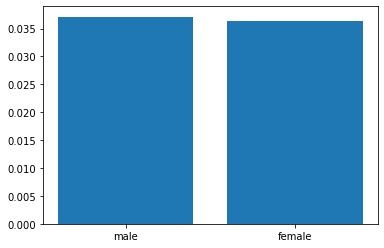

[0.0368144 0.0363686]


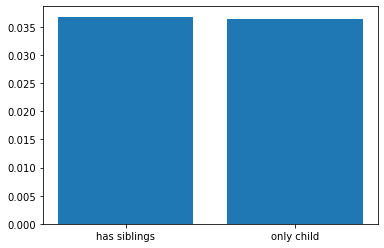

[0.03654036 0.03708732]


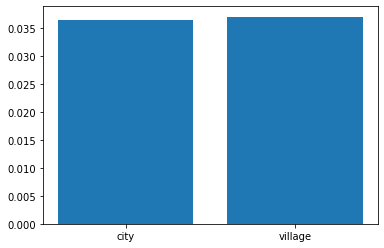

[0.0369901  0.03738477 0.0359288  0.03701084 0.03717923]


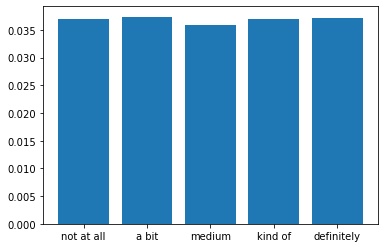

In [19]:
var_of_interest="Happiness_in_life"
contrast=["Gender","Only_child","Village_-_town","Finances"]
contrast_values=[["male","female"],["has siblings","only child"],["city","village"],["not at all","a bit","medium","kind of","definitely"]]
df=clean_data()
for j in range(len(contrast)):
    fig=plt.figure()

    def barlist(n): 
        if contrast[j]!="Finances":
            B=np.array([df[df[contrast[j]]==0][var_of_interest].mean(),df[df[contrast[j]]==1][var_of_interest].mean()])
        else:
            B=np.array([df[df[contrast[j]]==1][var_of_interest].mean(),df[df[contrast[j]]==2][var_of_interest].mean(),df[df[contrast[j]]==3][var_of_interest].mean(),df[df[contrast[j]]==4][var_of_interest].mean(),df[df[contrast[j]]==5][var_of_interest].mean()])
        return np.array([(B/101)*k for k in range(101)])[n,:]
    n=100 #Number of frames
    x=range(len(contrast_values[j]))
    print(barlist(1))
    barcollection = plt.bar(contrast_values[j],barlist(1))

    def animate(i):
        y=barlist(i+1)
        for i, b in enumerate(barcollection):
            b.set_height(y[i])

    anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                                 interval=100)

    anim.save(contrast[j]+'_bar.mp4',writer=animation.FFMpegWriter(fps=24))
    plt.show()

In [ ]:
import permutation_test as p
df=clean_data()
contrast=["Gender","Only_child","Village_-_town","Finances"]
data = df[df[contrast[0]]==0][var_of_interest]
ref_data = df[df[contrast[0]]==1][var_of_interest]

p_value = p.permutationtest(data, ref_data)

In [ ]:
from scipy import stats
from scipy.stats import norm
t,p=stats.ttest_ind(data,ref_data)
print(data.mean()-ref_data.mean())
print(t,p)
x=np.arange(-5,6,0.1)
tvals=stats.t.pdf(x,t)
plt.plot(x,tvals)
plt.show()
v=norm.pdf(x)
plt.plot(x,v)
plt.axvline(x=1.25,color="red")
#plt.axvline(x=-3.25,color="orange")
#plt.axvline(x=3.25,color="orange")
plt.show()

In [ ]:
var_of_interest="Happiness_in_life"
contrast=["Gender","Only_child","Village_-_town","Finances"]
contrast_values=[["male","female"],["has siblings","only child"],["city","village"],["not at all","a bit","medium","kind of","definitely"]]
df=clean_data()
for j in range(len(contrast)):
    print(df.corr()[var_of_interest][contrast[j]])
    print(pearsonr(df[var_of_interest], df[contrast[j]]))
    g=sns.pairplot(data=df,y_vars=var_of_interest,x_vars=contrast[j],kind="reg")
    g.fig.set_size_inches(5,5)
    plt.show()